# Exothermic Continuous Stirred Tank Reactor

## Description

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).

![Exothermic Reactor](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Agitated_vessel.svg/500px-Agitated_vessel.svg.png)

(Diagram By [Daniele Pugliesi](https://commons.wikimedia.org/wiki/User:Daniele_Pugliesi) - Own work, [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0), [Link](https://commons.wikimedia.org/w/index.php?curid=6915706))

## Reaction Kinetics

We assume the kinetics are dominated by a single first order reaction

$$A \xrightarrow{kc_A}{} \text{Products}$$

The reaction rate per unit volume is modeled as the product $kc_A$ where $c_A$ is the concentration of $A$. The rate constant $k(T)$ is a increases with temperature following the Arrehenius law

$$k(T) = k_0 e^{-\frac{E_a}{RT}}$$

$E_a$ is the activation energy, $R$ is the gas constant, $T$ is absolute temperature, and $k_0$ is the pre-exponential factor. 

We can see the strong temperature dependence by plotting $k(T)$ versus temperature over typical operating conditions.

<Axes: xlabel='Absolute Temperature [K]'>

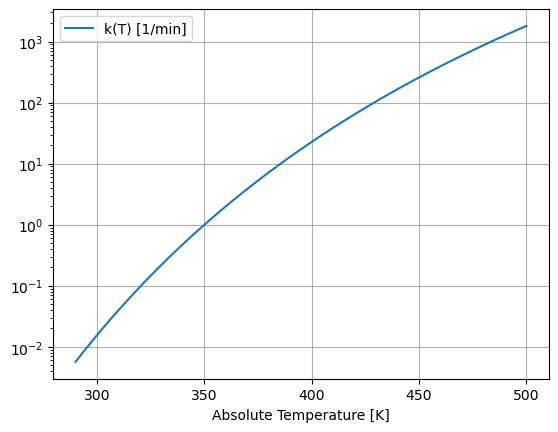

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

# Arrehnius parameters
Ea = 72750     # activation energy J/gmol
R = 8.314      # gas constant J/gmol/K
k0 = 7.2e10    # Arrhenius rate constant 1/min

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/(R*T))

T = np.linspace(290, 500)
df = pd.DataFrame({"Absolute Temperature [K]": T, "k(T) [1/min]": k(T)})
df.plot(x=0, y=1, logy=True, grid=True)

This graph shows the reaction rate changes by six orders of magnitude over the range of possible operating temperatures. Because an exothermic reaction releases heat faster at higher temperatures, there is a positive feedback that can potentially result in unstable process behavior.

## Model Equations and Parameter Values

The model consists of mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc_A}{dt} & = q(c_{A,f} - c_A) - Vk(T)c_A \\
\rho C_p V\frac{dT}{dt} & = \rho  C_p q(T_f - T) + (-\Delta H_R)Vk(T)c_A + UA(T_c - T)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c_A$ and $T$ give

\begin{align*}
\frac{dc_A}{dt} & = \frac{q}{V}(c_{A,f} - c_A)- k(T)c_A \\
\frac{dT}{dt} & = \frac{q}{V}(T_f - T) + \frac{-\Delta H_R}{\rho C_p}k(T)c_A + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}

which are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | :--- |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Coolant temperature | $T_c$ | 300 | K | Manipulated Variable |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |



This mathematical formulation is implemented as a function `simulate_cstr` that returns a `pandas` DataFrame object. The inputs to the function is a grid of points in time for the which a solution is required, initial conditions, and values for selected operating parameters. The remaining parameters are fixed in the body of the function. With this design, all calculations within the function require no access to parameters or function defined outside of `simulate_cstr`.

In [3]:
import pandas as pd
from scipy.integrate import solve_ivp

# study parameters
Tc  = 300.0     # Coolant temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]

def simulate_cstr(t_eval, Tc=Tc, cA0=cA0, T0=T0):
    
    # fixed model parameters
    Ea  = 72750     # activation energy J/gmol
    R   = 8.314     # gas constant J/gmol/K
    k0  = 7.2e10    # Arrhenius rate constant 1/min
    V   = 100.0     # Volume [L]
    rho = 1000.0    # Density [g/L]
    Cp  = 0.239     # Heat capacity [J/g/K]
    dHr = -5.0e4    # Enthalpy of reaction [J/mol]
    UA  = 5.0e4     # Heat transfer [J/min/K]
    q   = 100.0     # Flowrate [L/min]
    cAf = 1.0       # Inlet feed concentration [mol/L]
    Tf  = 350.0     # Inlet feed temperature [K]
    
    # Arrhenius rate expression
    def k(T):
        return k0*np.exp(-Ea/(R*T))

    # function to evaluate differential equations
    def deriv(t, y):
        cA, T = y
        dcAdt = (q/V)*(cAf - cA) - k(T)*cA
        dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
        return [dcAdt, dTdt]
    
    # solve ivp
    soln = solve_ivp(deriv, [min(t_eval), max(t_eval)], [cA0, T0], t_eval=t_eval)
    
    # return solution as a pandas dataframe
    df = pd.DataFrame({"Time": t_eval})
    df["cA"] = soln.y[0, :]
    df["T"] = soln.y[1, :]
    return df

We first define a visualization function that will be reused in later simulations.

array([<Axes: title={'center': 'Concentration'}, xlabel='Time'>,
       <Axes: title={'center': 'Temperature'}, xlabel='Time'>],
      dtype=object)

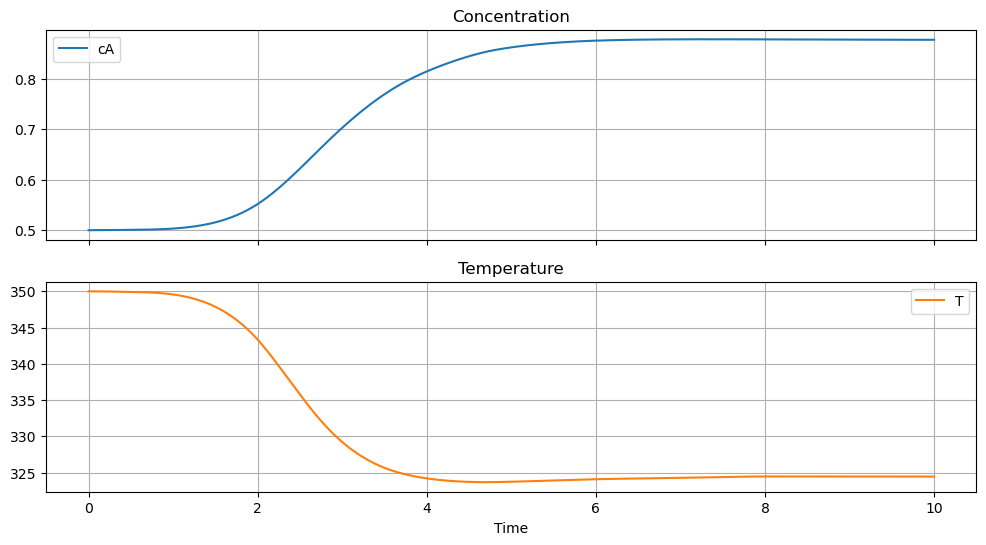

In [4]:
# time grid
t_final = 10.0
t_eval = np.linspace(0, t_final, 1001)

# simulate for default cooling temperature and initial conditions
df = simulate_cstr(t_eval)
df.plot(x="Time", subplots=True, title=["Concentration", "Temperature"], figsize=(12, 6), sharex=True, grid=True)

## Effect of Cooling Temperature

The primary means of controlling the reactoris through temperature of the cooling water jacket. The next calculations explore the effect of plus or minus change of 5 K in cooling water temperature on reactor behavior. These simulations reproduce the behavior shown in Example 2.5 SEMD.

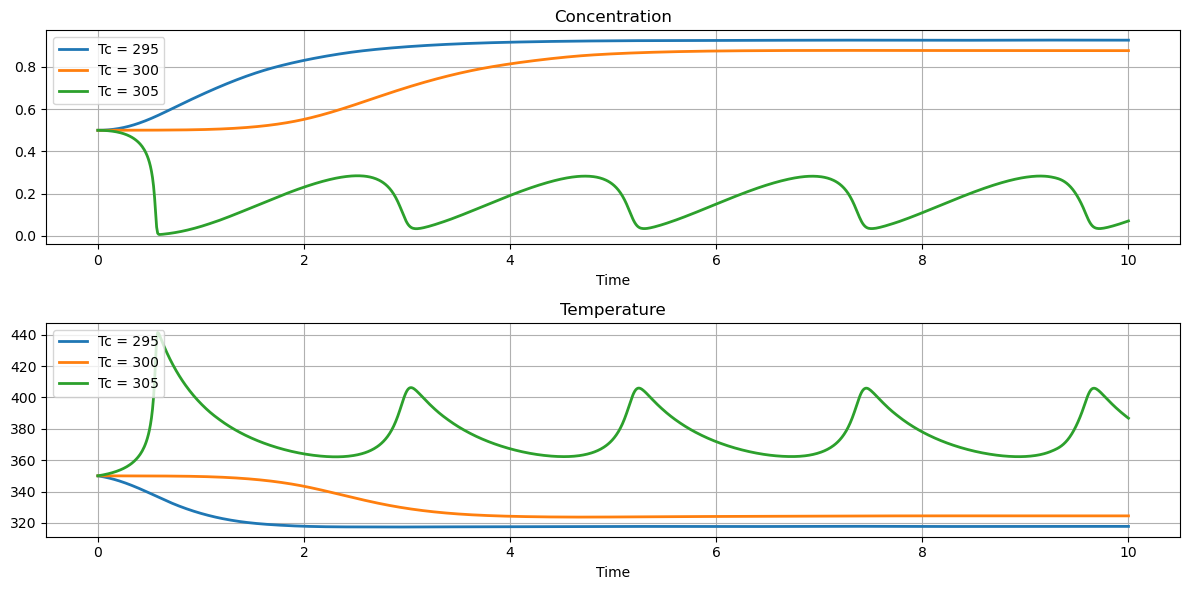

In [5]:
# create plot grid
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# simulate for a range of cooling temperatures
t_final = 10
t_eval = np.linspace(0, t_final, 1001)

for Tc in [295, 300, 305]:
    df = simulate_cstr(t_eval, Tc)
    df.plot(x="Time", y="cA", ax=ax[0], grid=True, title="Concentration", label=f"Tc = {Tc}", lw=2)
    df.plot(x="Time", y="T", ax=ax[1], grid=True, title="Temperature", label=f"Tc = {Tc}", lw=2)

fig.tight_layout()

## Interactive Simulation

Executing the following cell provides an interactive tool for exploring the relationship of cooling temperature with reactor behavior.  Use it to observe a thermal runaway, sustained osciallations, and low and high conversion steady states.

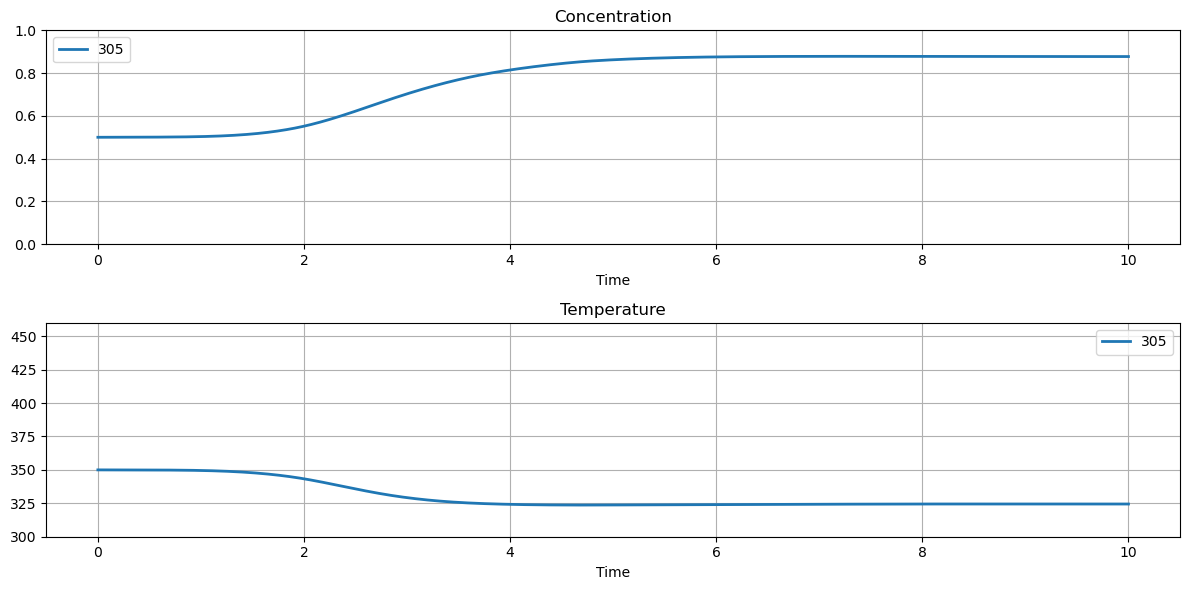

In [11]:
import matplotlib.pyplot as plt

# Install and uncomment these two packages to run the interactive widget
# from ipywidgets import interact
# from IPython.display import display

# initial simulation
t_final = 10.0
t_eval = np.linspace(0, t_final, 1001)
df = simulate_cstr(t_eval)

# plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
df.plot(x="Time", y="cA", ax=ax[0], ylim=(0, 1), grid=True, title="Concentration", lw=2)
df.plot(x="Time", y="T", ax=ax[1], ylim=(300, 460), grid=True, title="Temperature", lw=2)
fig.tight_layout()

# this close is needed to avoid duplicate plotter output
plt.close(fig)

# function to update and display the plot object
def sim(T_cooling, c_initial, T_initial):
    df = simulate_cstr(t_eval, T_cooling, c_initial, T_initial)
    ax[0].lines[0].set_ydata(df["cA"])
    ax[0].legend().get_texts()[0].set_text(str(Tc))
    ax[1].lines[0].set_ydata(df["T"])
    ax[1].legend().get_texts()[0].set_text(str(Tc))
    display(fig)

# uncomment the line below to run the interactive widget
# interact(sim, T_cooling = (290.0, 310.0), c_initial = (0.0, 1.0, 0.01), T_initial = (300, 400));

sim(T_cooling=300, c_initial=0.5, T_initial=350)


## Nullclines

The nullclines of two first-order differential equations are points in the phase plane for which one or the other of the two derivatives are zero.

\begin{align*}
V\frac{dc_A}{dt} & = 0 = q(c_{A,f} - c_A) - Vk(T)c_A \\
\rho C_pV\frac{dT}{dt} & = 0 = \rho C_p q(T_f - T) + (-\Delta H_R)Vk(T)c_A + UA(T_c-T)
\end{align*}

Solving each of equations for steady-state values $\bar{c}_A$, $\bar{T}$ gives two relations

\begin{align*}
\frac{d\bar{c}_A}{dt} = 0 \implies \bar{c}_A & = \frac{q c_{A,f}}{q + V k(\bar{T})} \\
\frac{d\bar{T}}{dt} = 0 \implies \bar{c}_A & = -\frac{\rho q C_p(T_f - \bar{T}) + UA(T_c - \bar{T})}{(-\Delta H_R)Vk(\bar{T})} 
\end{align*}

The intersection of the nullclines correspond to steady states. The relative positions of the nullclines provide valuable insight into the dynamics of a nonlinear system.

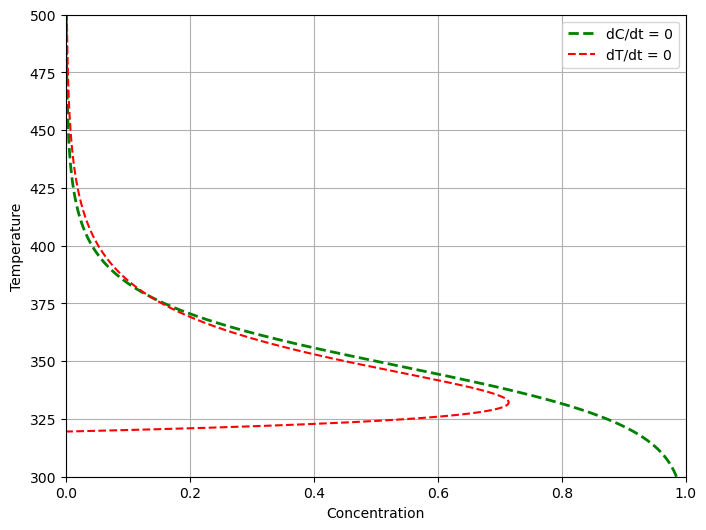

In [7]:
# plot nullclines
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAf = 1.0       # Inlet feed concentration [mol/L]
Tf  = 350.0     # Inlet feed temperature [K]

def plot_nullclines(ax, Tc=Tc):
    T = np.linspace(300.0, 500.0, 1000)
    df = pd.DataFrame({'T': T,  
                       "dC/dt = 0": (q/V)*cAf/((q/V) + k(T)),
                       "dT/dt = 0": (rho*q*Cp*(Tf - T) + UA*(Tc - T))/(V*dHr*k(T))})
    df.plot(x = 1, y = 0, lw=2, ax=ax, xlabel="Concentration", ylabel="Temperature", style={"T":"g--"})
    df.plot(x = 2, y = 0, ax=ax, grid=True, xlim=(0, 1), xlabel="Concentration", ylim = (300, 500), style={"T":"r--"})
    ax.legend(['dC/dt = 0','dT/dt = 0'])
    
fix, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_nullclines(ax, Tc)

## Phase Plane Analysis

The final analysis is display the simulation in both time and phase plane coordinates. The red circle is the initial point.

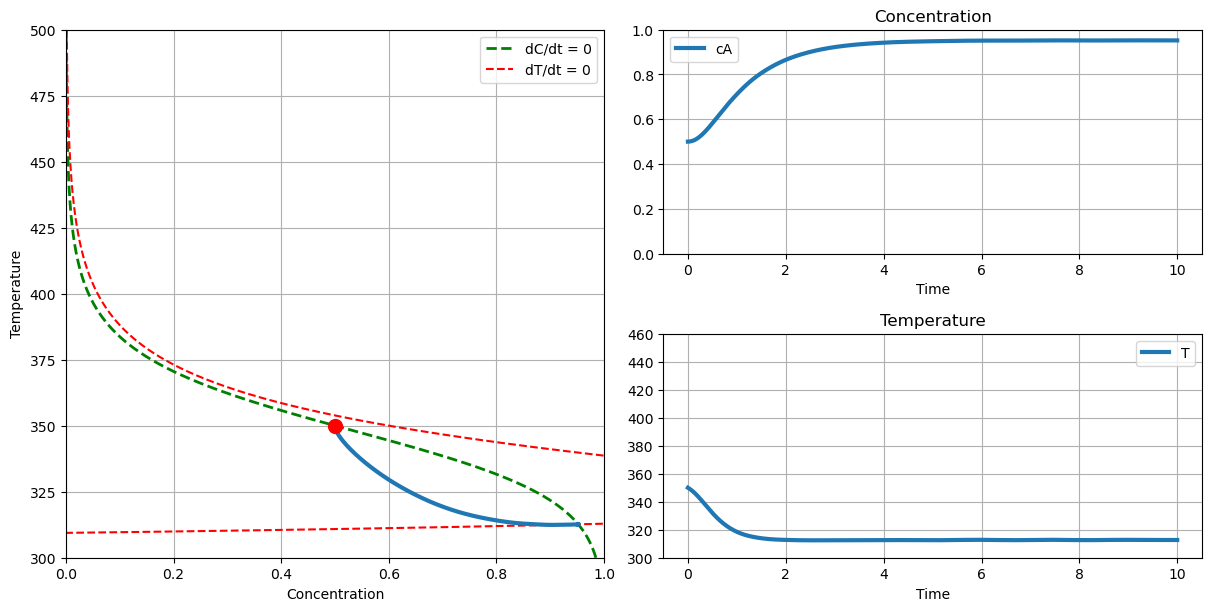

In [13]:
# set up figure window and axes
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# simulate
t_final = 10
t_eval = np.linspace(0, t_final, 1001)
df = simulate_cstr(t_eval)

# add plots
plot_nullclines(ax1)
ax1.plot(df["cA"], df["T"], lw=3)
ax1.plot(df.loc[0, "cA"], df.loc[0, "T"], 'r.', ms=20)
df.plot(x=0, y="cA", ax=ax2, grid=True, ylim=(0, 1), title="Concentration", lw=3)
df.plot(x=0, y="T", ax=ax3, grid=True, ylim=(300, 460), title="Temperature", lw=3)
plt.close(fig)

def plot_phase(T_cooling, c_initial, T_initial):
    df = simulate_cstr(t_eval, T_cooling, c_initial, T_initial)
    T = np.linspace(300.0, 500.0, 1000)
    ax1.lines[1].set_xdata((rho*q*Cp*(Tf - T) + UA*(T_cooling - T))/(V*dHr*k(T)))
    ax1.lines[2].set_xdata(df["cA"])
    ax1.lines[2].set_ydata(df["T"])
    ax1.lines[3].set_xdata([c_initial])
    ax1.lines[3].set_ydata([T_initial])
    ax2.lines[0].set_ydata(df["cA"])
    ax3.lines[0].set_ydata(df["T"])
    display(fig)

# Uncomment the line below to run the interactive widget
# interact(plot_phase, T_cooling = (290.0, 310.0), c_initial = (0.0, 1.0, 0.01), T_initial = (300, 400));
    
plot_phase(T_cooling=290., c_initial=0.5, T_initial=350.)

## Activities

**1.** Adjust the cooling temperature over the range of values from 290K to 310K, identify the cooling water temperatures at which you observe a qualitative difference in system behavior. Try to identify the following behaviors:

* Stable steady state
* Oscillatory steady state
* The onset of a thermal runaway condition

Describe the behavior using the nullclines.


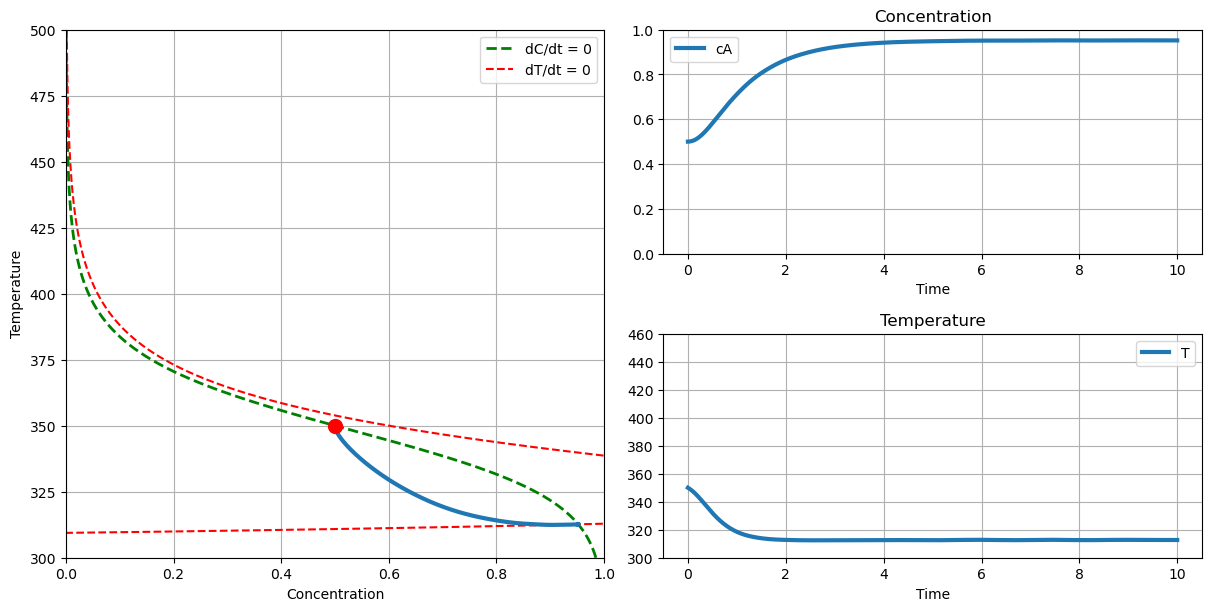

In [14]:
# stable steady state operation
plot_phase(T_cooling=290., c_initial=0.5, T_initial=350.)

In [ ]:
# 


**2.** Assume the reactor is start up with a tank of reactant feed with a concentration $c_A = 1$. What is the maximum initial temperature that would avoid thermal runaway during reactor startup?